# Using Parallel Magics

IPython has a few magics for working with your engines.

This assumes you have started an IPython cluster, either with the notebook interface,
or the `ipcluster/controller/engine` commands.

In [2]:
import ipyparallel as ipp
rc = ipp.Client()
dv = rc[:]
rc.ids

[0, 1, 2, 3]

Creating a Client registers the parallel magics `%px`, `%%px`, `%pxresult`, `pxconfig`, and `%autopx`.  
These magics are initially associated with a DirectView always associated with all currently registered engines.

Now we can execute code remotely with `%px`:

In [18]:
%px a=5

In [17]:
%px print(a)

[stdout:0] 5
[stdout:1] 5
[stdout:2] 5
[stdout:3] 5


In [19]:
%px a

Out[0:13]: 5

Out[1:13]: 5

Out[2:13]: 5

Out[3:13]: 5

In [20]:
with dv.sync_imports():
    import sys

importing sys on engine(s)


In [21]:
%px from __future__ import print_function
%px print("ERROR", file=sys.stderr)

[stderr:0] ERROR
[stderr:1] ERROR
[stderr:2] ERROR
[stderr:3] ERROR


You don't have to wait for results.  The `%pxconfig` magic lets you change the default blocking/targets for the `%px` magics:

In [22]:
%pxconfig --noblock

In [23]:
%px import time
%px time.sleep(5)
%px time.time()

<AsyncResult: execute>

But you will notice that this didn't output the result of the last command.
For this, we have `%pxresult`, which displays the output of the latest request:

In [10]:
%pxresult

Out[0:10]: 1544557530.2473688

Out[1:10]: 1544557530.2493215

Out[2:10]: 1544557530.2493215

Out[3:10]: 1544557530.2502975

Remember, an IPython engine is IPython, so you can do magics remotely as well!

In [13]:
%pxconfig --block
%px %matplotlib inline

In [4]:
%%px
import numpy as np
import matplotlib.pyplot as plt

`%%px` can also be used as a cell magic, for submitting whole blocks.
This one acceps `--block` and `--noblock` flags to specify
the blocking behavior, though the default is unchanged.


In [11]:
dv.scatter('id', dv.targets, flatten=True)
dv['stride'] = len(dv)

In [19]:
%%px --noblock
x = np.linspace(0,np.pi,1000)
for n in range(id,12, stride):
    print(n)
    plt.plot(x,np.sin(n*x))
plt.title("Plot %i" % id)

<AsyncResult: execute>

In [17]:
%pxresult

[stdout:0] 
1
5
9
[stdout:1] 
2
6
10
[stdout:2] 
3
7
11
[stdout:3] 
4
8


It also lets you choose some amount of the grouping of the outputs with `--group-outputs`:

The choices are:

* `engine` - all of an engine's output is collected together
* `type` - where stdout of each engine is grouped, etc. (the default)
* `order` - same as `type`, but individual displaypub outputs are interleaved.
  That is, it will output the first plot from each engine, then the second from each,
  etc.

[stdout:0] 
1
5
9


[output:0]

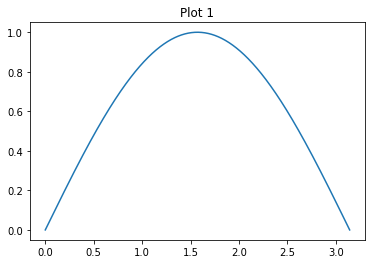

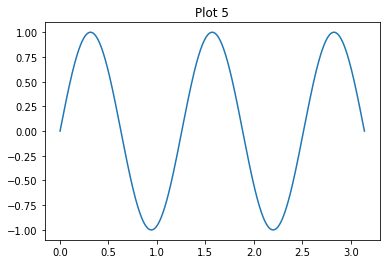

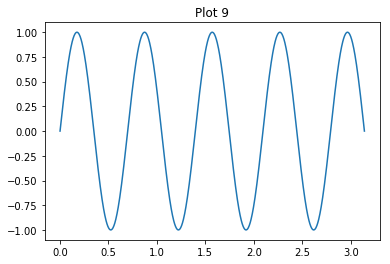

[stdout:1] 
2
6
10


[output:1]

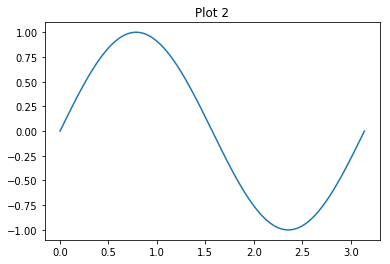

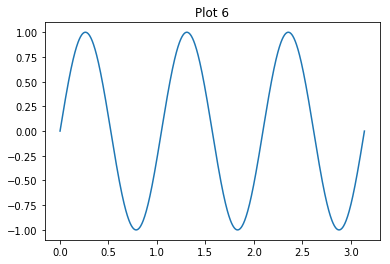

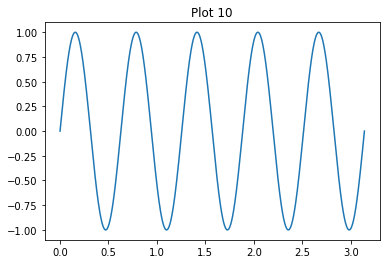

[stdout:2] 
3
7
11


[output:2]

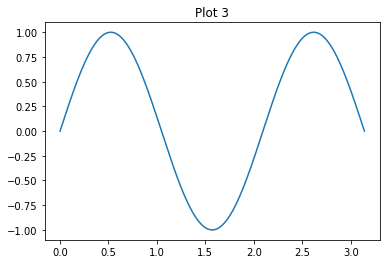

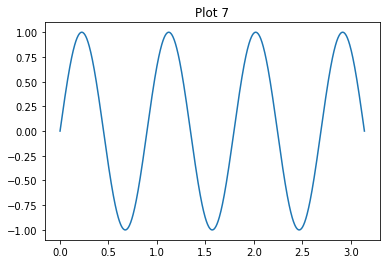

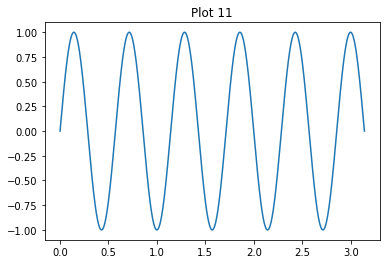

[stdout:3] 
4
8


[output:3]

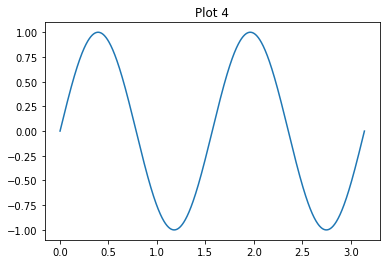

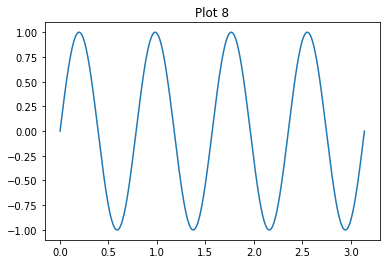

In [14]:
%%px --group-outputs=engine
x = np.linspace(0,np.pi,1000)
for n in range(id+1,12, stride):
    print(n)
    plt.figure()
    plt.plot(x,np.sin(n*x))
    plt.title("Plot %i" % n)

When you specify 'order', then individual display outputs (e.g. plots) will be interleaved.

`%pxresult` takes the same output-ordering arguments as `%%px`, 
so you can view the previous result in a variety of different ways with a few sequential calls to `%pxresult`:

In [ ]:
%pxresult --group-outputs=order

## Single-engine views

When a DirectView has a single target, the output is a bit simpler (no prefixes on stdout/err, etc.):

In [ ]:
from __future__ import print_function

def generate_output():
    """function for testing output
    
    publishes two outputs of each type, and returns something
    """
    
    import sys,os
    from IPython.display import display, HTML, Math
    
    print("stdout")
    print("stderr", file=sys.stderr)
    
    display(HTML("<b>HTML</b>"))
    
    print("stdout2")
    print("stderr2", file=sys.stderr)
    
    display(Math(r"\alpha=\beta"))
    
    return os.getpid()

dv['generate_output'] = generate_output

You can also have more than one set of parallel magics registered at a time.

The `View.activate()` method takes a suffix argument, which is added to `'px'`.

In [ ]:
e0 = rc[-1]
e0.block = True
e0.activate('0')

In [ ]:
%px0 generate_output()

In [ ]:
%px generate_output()

As mentioned above, we can redisplay those same results with various grouping:

In [ ]:
%pxresult --group-outputs order

In [ ]:
%pxresult --group-outputs engine

## Parallel Exceptions

When you raise exceptions with the parallel exception,
the CompositeError raised locally will display your remote traceback.

In [ ]:
%%px
from numpy.random import random
A = random((100,100,'invalid shape'))

## Remote Cell Magics

Remember, Engines are IPython too, so the cell that is run remotely by %%px can in turn use a cell magic.

In [6]:
%%px
%%timeit
from numpy.random import random
from numpy.linalg import norm
A = random((100,100))
norm(A, 2)

[stdout:0] 1.85 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[stdout:1] 2.23 ms ± 441 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[stdout:2] 2.21 ms ± 997 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
[stdout:3] 1.85 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Local Execution

As of IPython 1.0, you can instruct `%%px` to also execute the cell locally.
This is useful for interactive definitions,
or if you want to load a data source everywhere,
not just on the engines.

In [ ]:
%%px --local
import os
thispid = os.getpid()
print(thispid)